In [44]:
from __future__ import print_function
from collections import defaultdict
from itertools import count
import numpy as np
import math
import random 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [45]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

In [46]:
class Environment(object):
    """
    The Tic-Tac-Toe Environment
    """
    # possible ways to win
    win_set = frozenset([(0,1,2), (3,4,5), (6,7,8), # horizontal
                         (0,3,6), (1,4,7), (2,5,8), # vertical
                         (0,4,8), (2,4,6)])         # diagonal
    # statuses
    STATUS_VALID_MOVE = 'valid'
    STATUS_INVALID_MOVE = 'inv'
    STATUS_WIN = 'win'
    STATUS_TIE = 'tie'
    STATUS_LOSE = 'lose'
    STATUS_DONE = 'done'

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the game to an empty board."""
        self.grid = np.array([0] * 9) # grid
        self.turn = 1                 # whose turn it is
        self.done = False             # whether game is done
        return self.grid

    def render(self):
        """Print what is on the board."""
        map = {0:'.', 1:'x', 2:'o'} # grid label vs how to plot
        print(''.join(map[i] for i in self.grid[0:3]))
        print(''.join(map[i] for i in self.grid[3:6]))
        print(''.join(map[i] for i in self.grid[6:9]))
        print('====')

    def check_win(self):
        """Check if someone has won the game."""
        for pos in self.win_set:
            s = set([self.grid[p] for p in pos])
            if len(s) == 1 and (0 not in s):
                return True
        return False

    def step(self, action):
        """Mark a point on position action."""
        assert type(action) == int and action >= 0 and action < 9
        # done = already finished the game
        if self.done:
            return self.grid, self.STATUS_DONE, self.done
        # action already have something on it
        if self.grid[action] != 0:
            return self.grid, self.STATUS_INVALID_MOVE, self.done
        # play move
        self.grid[action] = self.turn
        if self.turn == 1:
            self.turn = 2
        else:
            self.turn = 1
        # check win
        if self.check_win():
            self.done = True
            return self.grid, self.STATUS_WIN, self.done
        # check tie
        if all([p != 0 for p in self.grid]):
            self.done = True
            return self.grid, self.STATUS_TIE, self.done
        return self.grid, self.STATUS_VALID_MOVE, self.done

    def random_step(self):
        """Choose a random, unoccupied move on the board to play."""
        pos = [i for i in range(9) if self.grid[i] == 0]
        move = random.choice(pos)
        return self.step(move)

    def play_against_random(self, action):
        """Play a move, and then have a random agent play the next move."""
        state, status, done = self.step(action)
        if not done and self.turn == 2:
            state, s2, done = self.random_step()
            if done:
                if s2 == self.STATUS_WIN:
                    status = self.STATUS_LOSE
                elif s2 == self.STATUS_TIE:
                    status = self.STATUS_TIE
                else:
                    raise ValueError("???")
        return state, status, done

# Part 1. Self-playing using render( ) and step( )

In [47]:
env = Environment()
env.render()
env.step(4)
env.render()
print(env.check_win())
env.step(1)
env.render()
print(env.check_win())
env.step(5)
env.render()
print(env.check_win())
env.step(3)
env.render()
print(env.check_win())
env.step(0)
env.render()
print(env.check_win())
env.step(1)
env.render()
print(env.check_win())
env.step(6)
env.render()
print(env.check_win())
env.step(8)
env.render()
print(env.check_win())

...
...
...
====
...
.x.
...
====
False
.o.
.x.
...
====
False
.o.
.xx
...
====
False
.o.
oxx
...
====
False
xo.
oxx
...
====
False
xo.
oxx
...
====
False
xo.
oxx
o..
====
False
xo.
oxx
o.x
====
True


# Part 2. Implementing Policy

In [212]:
class Policy(nn.Module):
    """
    The Tic-Tac-Toe Policy
    """
    def __init__(self, input_size=27, hidden_size=64, output_size=9):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(27, 64)
        self.fc2 = nn.Linear(64, 9)
        print(hidden_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
    


In [49]:
def select_action(policy, state):
    """Samples an action from the policy at the state."""
    state = torch.from_numpy(state).long().unsqueeze(0)
    state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
    pr = policy(Variable(state))
    m = torch.distributions.Categorical(pr)
    action = m.sample()
    log_prob = torch.sum(m.log_prob(action))
    return action.data[0], log_prob


# Part 3. Computing Returns

In [61]:
def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
      @param rewards: list of floats, where rewards[t] is the reward
                      obtained at time step t
      @param gamma: the discount factor
      @returns list of floats representing the episode's returns
          G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... 

    >>> compute_returns([0,0,0,1], 1.0)
    [1.0, 1.0, 1.0, 1.0]
    >>> compute_returns([0,0,0,1], 0.9)
    [0.7290000000000001, 0.81, 0.9, 1.0]
    >>> compute_returns([0,-0.5,5,0.5,-10], 0.9)
    [-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10.0]
    """
    discounted_rewards = []
    for t in range(len(rewards)):
        discounted_rewards.append(returns(rewards[t:], gamma))
    return discounted_rewards


def returns(rewards, gamma=1.0):
    """
    returns the discounted(float) reward at time t.
    """
    if len(rewards) == 1:
        return rewards[0]
    else:
        return gamma * np.asarray(returns(rewards[1:], gamma)) + rewards[0]

In [52]:
rewards = [0,0,0,1]
gamma=0.9
print(compute_returns(rewards, gamma))

[0.7290000000000001, 0.81, 0.9, 1]


In [53]:
rewards = [0,-0.5,5,0.5,-10]
gamma=0.9
print(compute_returns(rewards, gamma))

[-2.5965000000000003, -2.8850000000000002, -2.6500000000000004, -8.5, -10]


In [54]:
def finish_episode(saved_rewards, saved_logprobs, gamma=1.0):
    """Samples an action from the policy at the state."""
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)
    policy_loss = []
    returns = compute_returns(saved_rewards, gamma)
    returns = torch.Tensor(returns)
    # subtract mean and std for faster training
    returns = (returns - returns.mean()) / (returns.std() +
                                            np.finfo(np.float32).eps)
    for log_prob, reward in zip(saved_logprobs, returns):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward(retain_graph=True)
    # note: retain_graph=True allows for multiple calls to .backward()
    # in a single step

# Part 4. Get rewards

In [154]:
def get_reward(status):
    """Returns a numeric given an environment status."""
    return {
            Environment.STATUS_VALID_MOVE  : 0, # TODO
            Environment.STATUS_INVALID_MOVE: -2,
            Environment.STATUS_WIN         : 1,
            Environment.STATUS_TIE         : 0,
            Environment.STATUS_LOSE        : -2
    }[status]


In [205]:
def train(policy, env, gamma=1.0, log_interval=1000, size=64):
    """Train policy gradient."""
    
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)

    num_episode = []
    avg_rewards = []
    inv_count = 0
    
    optimizer = optim.Adam(policy.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=10000, gamma=0.9)
    running_reward = 0

    for i_episode in count(1):
#         if i_episode > 50001:
        if i_episode > 5001:
            break
        saved_rewards = []
        saved_logprobs = []
        state = env.reset()
        done = False
        while not done:
            action, logprob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            if status == 'inv':
                inv_count += 1
            reward = get_reward(status)
            saved_logprobs.append(logprob)
            saved_rewards.append(reward)

        R = compute_returns(saved_rewards)[0]
        running_reward += R

        finish_episode(saved_rewards, saved_logprobs, gamma)

        if i_episode % log_interval == 0:
            print('Episode {}\tAverage return: {:.2f}'.format(
                i_episode,
                running_reward / log_interval))
            print('invalid moves in the 1000 episode is:' + str(inv_count))
            # Saving result for training curve
            num_episode.append(i_episode)
            avg_rewards.append(running_reward / log_interval)
            inv_count = 0
            running_reward = 0

        if i_episode % (log_interval) == 0:
            torch.save(policy.state_dict(),
                       "./train/policy-%d_%d.pkl" % (i_episode,size))

        if i_episode % 1 == 0: # batch_size
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
    return num_episode, avg_rewards

In [193]:
def first_move_distr(policy, env):
    """Display the distribution of first moves."""
    state = env.reset()
    state = torch.from_numpy(state).long().unsqueeze(0)
    state = torch.zeros(3,9).scatter_(0,state,1).view(1,27)
    pr = policy(Variable(state))
    return pr.data


def load_weights(policy, episode, size=64):
    """Load saved weights"""
    weights = torch.load("./train/policy-%d_%d.pkl" % (episode, size))
    policy.load_state_dict(weights)

# Part 5. Training

In [164]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

policy = Policy()
env = Environment()
num_episode, avg_rewards = train(policy, env)

# Environment.STATUS_VALID_MOVE  : 0, # TODO
# Environment.STATUS_INVALID_MOVE: -2,
# Environment.STATUS_WIN         : 1,
# Environment.STATUS_TIE         : 0,
# Environment.STATUS_LOSE        : -2

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Episode 1000	Average return: -8.03
invalid moves in the 1000 episode is:4050
Episode 2000	Average return: -2.44
invalid moves in the 1000 episode is:1305
Episode 3000	Average return: -0.67
invalid moves in the 1000 episode is:417
Episode 4000	Average return: -0.15
invalid moves in the 1000 episode is:185
Episode 5000	Average return: 0.12
invalid moves in the 1000 episode is:108
Episode 6000	Average return: 0.33
invalid moves in the 1000 episode is:84
Episode 7000	Average return: 0.35
invalid moves in the 1000 episode is:44
Episode 8000	Average return: 0.50
invalid moves in the 1000 episode is:17
Episode 9000	Average return: 0.33
invalid moves in the 1000 episode is:21
Episode 10000	Average return: 0.27
invalid moves in the 1000 episode is:13
Episode 11000	Average return: 0.49
invalid moves in the 1000 episode is:11
Episode 12000	Average return: 0.45
invalid moves in the 1000 episode is:11
Episode 13000	Average return: 0.32
invalid moves in the 1000 episode is:9
Episode 14000	Average re

In [ ]:
# class Policy(nn.Module):
#     """
#     The Tic-Tac-Toe Policy
#     """
#     def __init__(self, input_size=27, hidden_size=64, output_size=9):
#         super(Policy, self).__init__()
#         self.fc1 = nn.Linear(27, 64)
#         self.fc2 = nn.Linear(64, 9)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.softmax(x)

Tuning Parameters - Number of hidden Layers

training with hidden layer size of 32
32


/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


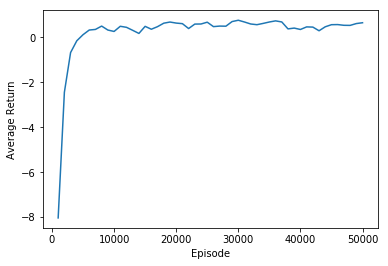

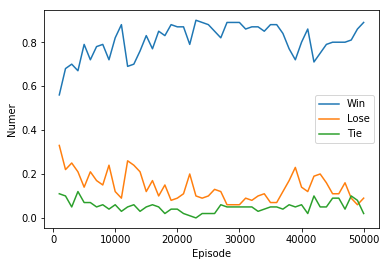

Win rate is: 0.89
Lose rate is: 0.09
Tie rate is: 0.02
training with hidden layer size of 64
64


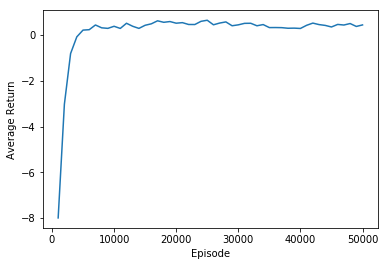

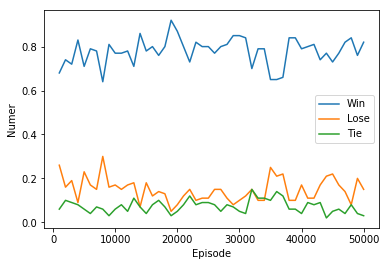

Win rate is: 0.82
Lose rate is: 0.15
Tie rate is: 0.03
training with hidden layer size of 128
128


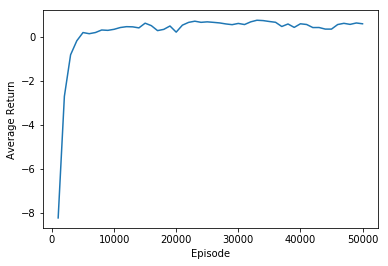

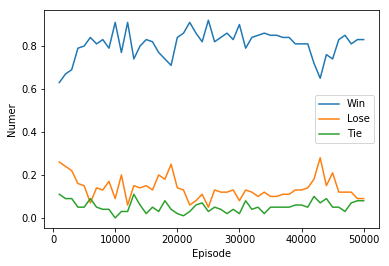

Win rate is: 0.83
Lose rate is: 0.09
Tie rate is: 0.08


In [190]:
hidden_size_list = [32,64,128]
# hidden_size_list = [16,32,64,96,128,160,192,224,256]
for size in hidden_size_list:
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)

    print('training with hidden layer size of ' + str(size))
    policy = Policy(hidden_size=size)
    env = Environment()
    num_episode, avg_rewards = train(policy, env, size)
    
    # Plot training curve
    plt.plot(num_episode, avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.savefig("./pics/training_curve%d.png"%size)
    plt.show()
    
    # Plot performance 
    max_ep = 50001
    win_results = []
    lose_results = []
    tie_results = []

    episodes = range(1000,max_ep,1000)

    for ep in episodes:
        load_weights(policy, ep, size)
        win, lose, tie = get_results(policy, ep)
        win_results.append(win)
        lose_results.append(lose)
        tie_results.append(tie)

    # Plotting the performance over training
    plt.plot(episodes, win_results, episodes, lose_results, episodes, tie_results)
    plt.legend(['Win', 'Lose','Tie'])
    plt.xlabel('Episode')
    plt.ylabel('Numer')
    plt.savefig("./pics/results%d.png"%size)
    plt.show()
    
    # Printing Performance for trained model
    print('Win rate is: ' + str(win_results[-1]))
    print('Lose rate is: ' + str(lose_results[-1]))
    print('Tie rate is: ' + str(tie_results[-1]))
    

training with hidden layer size of 32
32
Episode 1000	Average return: -8.03
invalid moves in the 1000 episode is:4050
Episode 2000	Average return: -2.44
invalid moves in the 1000 episode is:1305
Episode 3000	Average return: -0.67
invalid moves in the 1000 episode is:417
Episode 4000	Average return: -0.15
invalid moves in the 1000 episode is:185
Episode 5000	Average return: 0.12
invalid moves in the 1000 episode is:108


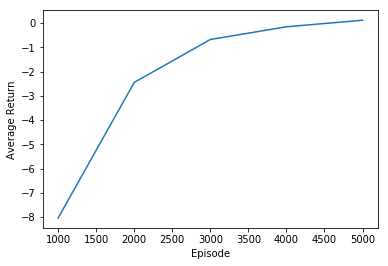

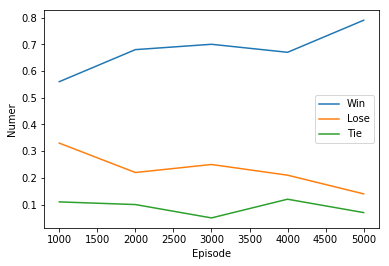

Win rate is: 0.79
Lose rate is: 0.14
Tie rate is: 0.07
training with hidden layer size of 64
64
Episode 1000	Average return: -8.03
invalid moves in the 1000 episode is:4050
Episode 2000	Average return: -2.44
invalid moves in the 1000 episode is:1305
Episode 3000	Average return: -0.67
invalid moves in the 1000 episode is:417
Episode 4000	Average return: -0.15
invalid moves in the 1000 episode is:185
Episode 5000	Average return: 0.12
invalid moves in the 1000 episode is:108


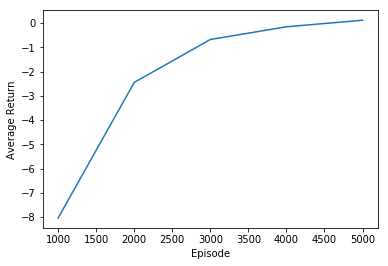

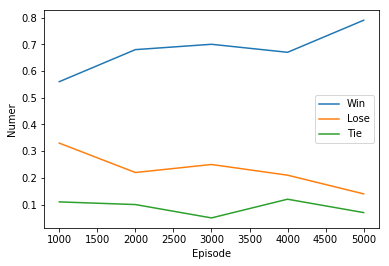

Win rate is: 0.79
Lose rate is: 0.14
Tie rate is: 0.07
training with hidden layer size of 128
128
Episode 1000	Average return: -8.03
invalid moves in the 1000 episode is:4050
Episode 2000	Average return: -2.44
invalid moves in the 1000 episode is:1305
Episode 3000	Average return: -0.67
invalid moves in the 1000 episode is:417
Episode 4000	Average return: -0.15
invalid moves in the 1000 episode is:185
Episode 5000	Average return: 0.12
invalid moves in the 1000 episode is:108


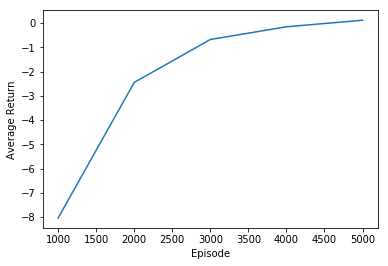

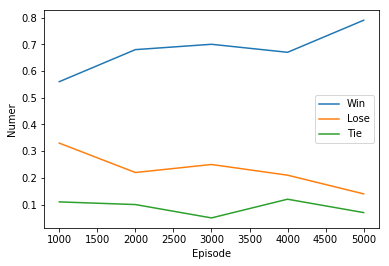

Win rate is: 0.79
Lose rate is: 0.14
Tie rate is: 0.07


In [213]:
hidden_size_list = [32,64,128]
# hidden_size_list = [16,32,64,96,128,160,192,224,256]
for size in hidden_size_list:
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)

    print('training with hidden layer size of ' + str(size))
    policy = Policy(hidden_size=size)
    env = Environment()
    num_episode, avg_rewards = train(policy, env, size = size)
    
    # Plot training curve
    plt.plot(num_episode, avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.savefig("./pics/training_curve%d.png"%size)
    plt.show()
    
    # Plot performance 
#     max_ep = 50001
    max_ep = 5001
    win_results = []
    lose_results = []
    tie_results = []

    episodes = range(1000,max_ep,1000)

    for ep in episodes:
        load_weights(policy, ep, size)
        win, lose, tie = get_results(policy, ep)
        win_results.append(win)
        lose_results.append(lose)
        tie_results.append(tie)

    # Plotting the performance over training
    plt.plot(episodes, win_results, episodes, lose_results, episodes, tie_results)
    plt.legend(['Win', 'Lose','Tie'])
    plt.xlabel('Episode')
    plt.ylabel('Numer')
    plt.savefig("./pics/results%d.png"%size)
    plt.show()
    
    # Printing Performance for trained model
    print('Win rate is: ' + str(win_results[-1]))
    print('Lose rate is: ' + str(lose_results[-1]))
    print('Tie rate is: ' + str(tie_results[-1]))
    

Plotting Training Curve

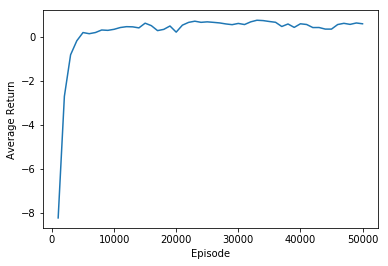

In [191]:
plt.plot(num_episode, avg_rewards)
# plt.legend(['Validation set', 'Training set','Test set'])
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.savefig("./pics/training_curve.png")
plt.show()

Get number of First-move Distribution

In [166]:
ep = 50000
load_weights(policy, ep)
print(first_move_distr(policy, env))


 0.0001  0.0002  0.9703  0.0000  0.0026  0.0001  0.0024  0.0000  0.0243
[torch.FloatTensor of size 1x9]



/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


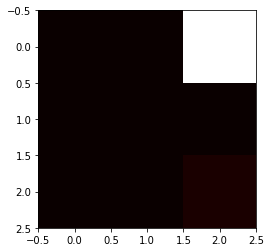

In [167]:
a = first_move_distr(policy, env)
a = np.resize(a,(3,3))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

Part5(c). Playing 100 games against random 

In [168]:
def part5d_1():
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)
    
    N = 100
    win = 0
    lose = 0
    tie = 0
    policy = Policy()
    env = Environment()
    ep = 50000
    load_weights(policy, ep)

    for i in range(N):
        state = env.reset()
        done = False
        while not done:
            action, log_prob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
        if(status == 'win'):
            win += 1
        elif(status == 'lose'):
            lose += 1
        else:
            tie += 1
            
    print('The agent wins %d times'%win)
    print('loses %d times'%lose)
    print('ties %d times'%tie)
    
    return win, lose, tie


In [169]:
win, lose, tie = part5d_1()

The agent wins 89 times
loses 7 times
ties 4 times


/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Displaying 5 games the agent playing against random

In [174]:
def part5d_2():
    
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)

    n = 1
    win = 0
    lose = 0
    tie = 0
    policy = Policy()
    env = Environment()
    ep = 50000
    load_weights(policy, ep) # Load trained results from saved files

    while n <= 5:
        print('Playing game number %d'%n)
        n += 1
        state = env.reset()
        done = False
        while not done:
            action, log_prob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
            env.render()
        if(status == 'win'):
            win += 1
        elif(status == 'lose'):
            lose += 1
        else:
            tie += 1
        print('The agent %ss \n'%status)


In [175]:
part5d_2()

Playing game number 1
..x
o..
...
====
..x
o..
o.x
====
..x
o.x
o.x
====
The agent wins 

Playing game number 2
.ox
...
...
====
.ox
.xo
...
====
oox
.xo
..x
====
oox
.xo
x.x
====
The agent wins 

Playing game number 3
..x
...
..o
====
..x
.xo
..o
====
..x
.xo
x.o
====
The agent wins 

Playing game number 4
..x
...
..o
====
..x
.x.
.oo
====
..x
.x.
xoo
====
The agent wins 

Playing game number 5
..x
...
.o.
====
.ox
...
.ox
====
.ox
..x
.ox
====
The agent wins 



/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


# Part 6

Use the model checkpoints saved throughout training to explore how the win / lose / tie rate changed throughout training. In your report, include graphs that illustrate this, as well as your conclusions in English.

In [176]:
def get_results(policy, ep):
    
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)
    
    N = 100
    win = 0.0
    lose = 0.0
    tie = 0.0
   
    for i in range(N):
        state = env.reset()
        done = False
        while not done:
            action, log_prob = select_action(policy, state)
            state, status, done = env.play_against_random(action)
        if(status == 'win'):
            win += 1
        elif(status == 'lose'):
            lose += 1
        else:
            tie += 1

    return win/100, lose/100, tie/100



In [177]:
def part_6():
    
    np.random.seed(1)
    random.seed(1)
    torch.manual_seed(1)
    
    policy = Policy()
    env = Environment()
    max_ep = 50001
    win_results = []
    lose_results = []
    tie_results = []

    episodes = range(1000,max_ep,1000)

    for ep in episodes:
        load_weights(policy, ep)
        win, lose, tie = get_results(policy, ep)
        win_results.append(win)
        lose_results.append(lose)
        tie_results.append(tie)

    # Plotting the performance over training
    plt.plot(episodes, win_results, episodes, lose_results, episodes, tie_results)
    plt.legend(['Win', 'Lose','Tie'])
    plt.xlabel('Episode')
    plt.ylabel('Numer')
    plt.savefig("./pics/results.png")
    plt.show()
    
    # Printing Performance for trained model
    print('Win rate is: ' + str(win_results[-1]))
    print('Lose rate is: ' + str(lose_results[-1]))
    print('Tie rate is: ' + str(tie_results[-1]))
    

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


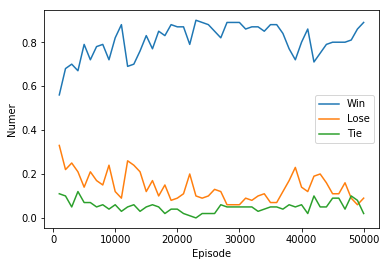

Win rate is: 0.89
Lose rate is: 0.09
Tie rate is: 0.02


In [178]:
part_6()

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


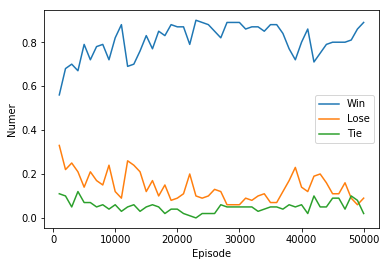

Win rate is: 0.89
Lose rate is: 0.09
Tie rate is: 0.02


In [179]:
part_6()

# Part 7

For your final trained model, show π, the learned distribution over the first move. (You may use the first_move_distr function provided) What has your model learned? Does the distribution make sense?

Explore how the distribution over the first move has changed throughout training.

/Users/yingxue_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


(51, 9)
(9, 50)


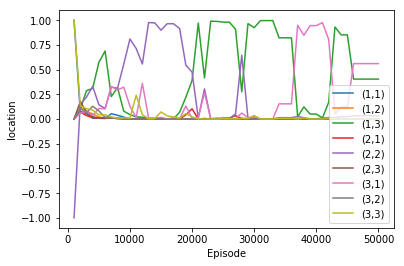

In [112]:
max_ep = 50001
episodes = range(1000,max_ep,1000)

results = np.empty((1,9))
for ep in episodes:
    load_weights(policy, ep)
    arr = np.asarray(first_move_distr(policy, env))
    results = np.vstack((results, arr))

print(results.shape)
results = results[:-1].T
print(results.shape)


# Ploting 
plt.plot(episodes, results[0], episodes, results[1], episodes, results[2],episodes, results[3],episodes, results[4],episodes, results[5],episodes, results[6],episodes, results[7],episodes, results[8])
plt.legend(['(1,1)', '(1,2)','(1,3)','(2,1)', '(2,2)','(2,3)','(3,1)', '(3,2)','(3,3)'])
plt.xlabel('Episode')
plt.ylabel('location')
plt.savefig("./pics/distribution.png")
plt.show()
